<a href="https://colab.research.google.com/github/neuroqudit/pykoppu/blob/main/notebooks/09_well_placement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Well Placement Optimization with KOPPU

This notebook demonstrates how to solve the Well Placement Optimization problem using the KOPPU OOS.
The goal is to select optimal locations for oil wells on a grid to maximize production value while respecting budget and minimum distance constraints.

## 1. Problem Formulation

Given a set of candidate locations $L$, each with an estimated value $v_i$ and drilling cost $c_i$, we want to select a subset of locations to maximize total value:

$$ \text{Maximize} \sum_{i \in S} v_i $$

Subject to:
1.  **Budget Constraint**: $\sum_{i \in S} c_i \le B$
2.  **Distance Constraint**: For any pair $i, j \in S$, $dist(i, j) \ge d_{min}$

In [1]:
!pip install pykoppu==0.2.34a0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.1 MB/s eta 0:00:00


In [3]:
import sys
import os
import numpy as np

# Ensure we can import the local pykoppu package
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pykoppu as pk

# 1. Define Candidate Locations (Grid)
# Create a 5x5 grid with random values
np.random.seed(42)
grid_size = 5
locations = []
idx = 0
for x in range(grid_size):
    for y in range(grid_size):
        # Value correlates with being near center (2,2)
        dist_center = np.sqrt((x-2)**2 + (y-2)**2)
        base_value = 100 * np.exp(-dist_center/2.0)
        value = base_value + np.random.uniform(-10, 10)
        cost = 10.0 + np.random.uniform(0, 5)

        locations.append({
            'id': idx,
            'x': float(x),
            'y': float(y),
            'value': max(0, value),
            'cost': cost
        })
        idx += 1

budget = 50.0
min_dist = 1.5 # Prevents adjacent wells (dist=1), allows diagonal (dist=1.414) if < 1.5? No, 1.414 < 1.5. So diagonal also blocked.
# Let's set min_dist = 1.1 to block adjacent but allow diagonal.
min_dist = 1.1

print(f"Generated {len(locations)} candidate locations.")

Generated 25 candidate locations.


## 2. PUBO Mapping

We map this to a QUBO problem:

$$ H = H_{value} + H_{budget} + H_{dist} $$

1.  **Value**: $H_{value} = \sum -v_i x_i$
2.  **Budget**: $H_{budget} = P_{budget} (\sum c_i x_i - B)^2$
3.  **Distance**: $H_{dist} = \sum_{dist(i,j) < d_{min}} P_{dist} x_i x_j$

Mapping to OPU...
Solving...
Visualizing OPU Dynamics...


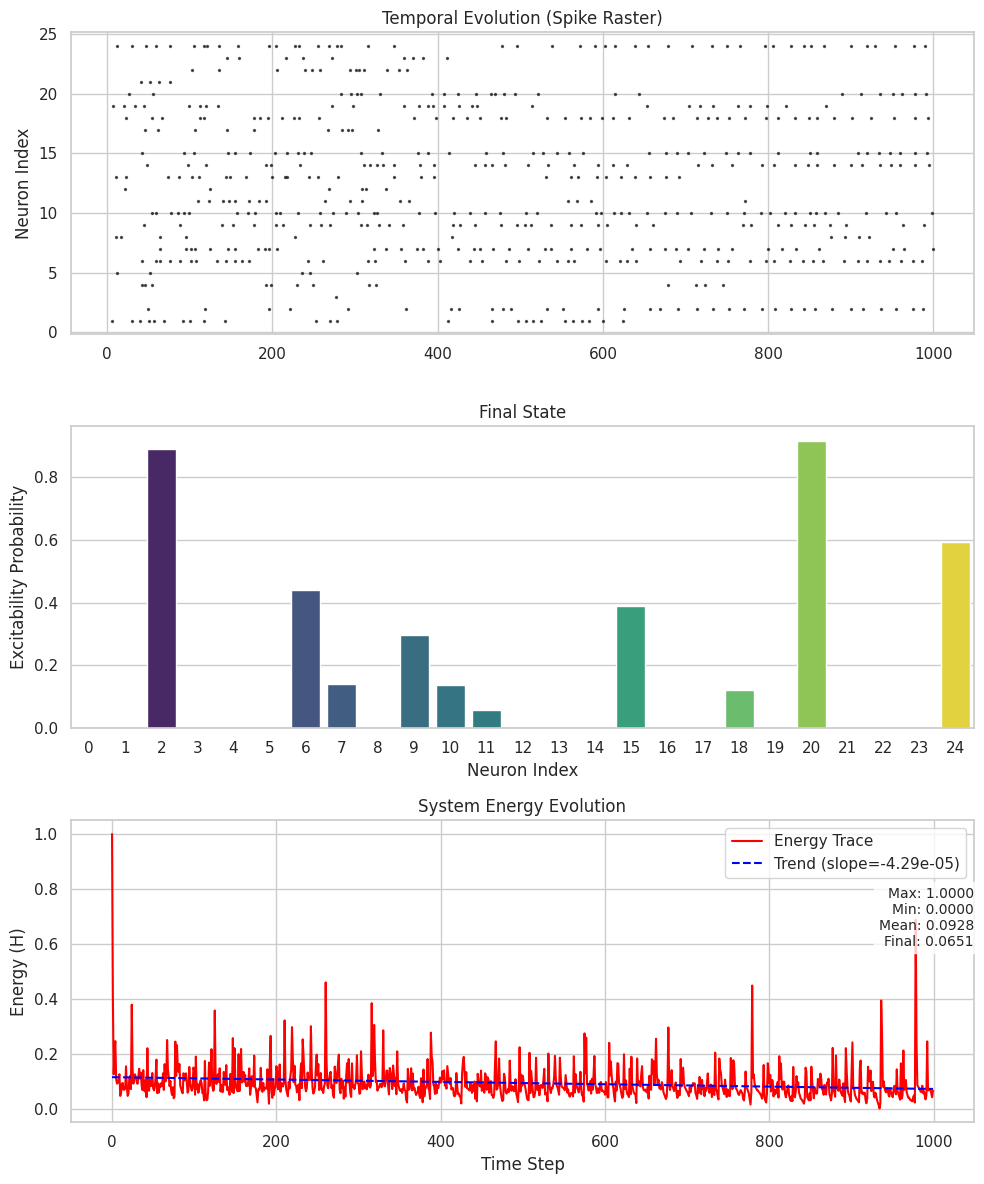

In [4]:
# 2. Create Well Placement Problem
print("Mapping to OPU...")
problem = pk.problems.energy.WellPlacement(
    locations,
    budget=budget,
    min_dist=min_dist,
    penalty_budget=10.0,
    penalty_dist=50.0 # High penalty for safety
)

# 3. Solve
print("Solving...")
process = pk.oos.Process(problem, backend='cpu', t=1000)
result = process.run()

# 4. Display OPU Dynamics
print("Visualizing OPU Dynamics...")
result.plot()

## 3. Solution Analysis

We visualize the optimal well locations on the grid. Red stars indicate selected drilling sites.

Visualizing Solution...


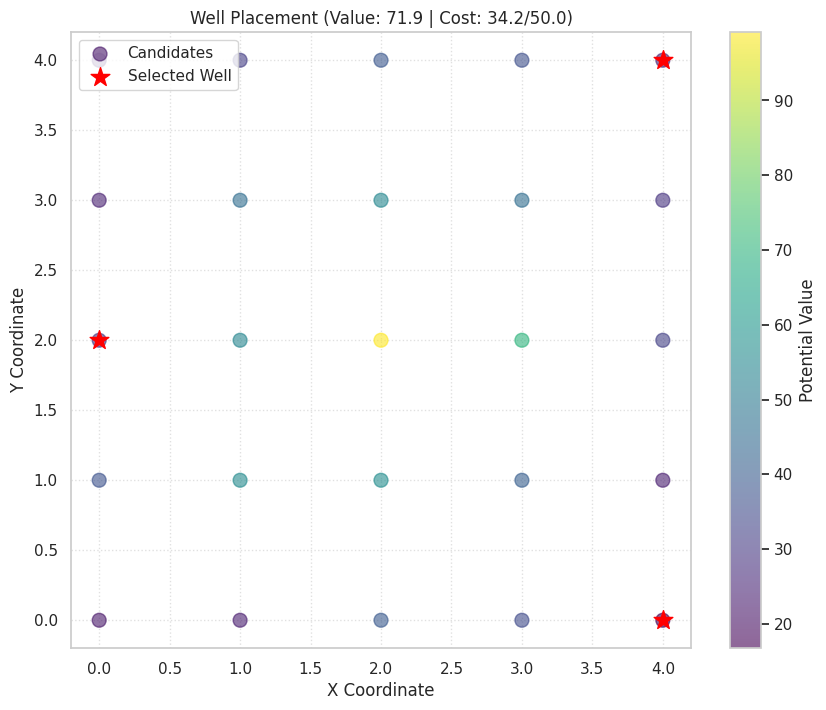


Total Value: 71.91
Total Cost: 34.18 (Budget: 50.0)
Valid: True
Selected Wells: 3


In [5]:
# 5. Analyse Solution
print("Visualizing Solution...")
problem.plot(result, threshold=0.5)

# Metrics
metrics = problem.evaluate(result.solution)
print(f"\nTotal Value: {metrics['total_value']:.2f}")
print(f"Total Cost: {metrics['total_cost']:.2f} (Budget: {metrics['budget']})")
print(f"Valid: {metrics['valid']}")
print(f"Selected Wells: {metrics['selected_count']}")